In [ ]:
import os
spark_version = 'spark-3.0.2'
os.environ['spark-3.0.2']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:14 http://archive

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigData-Challenge").config("spark.driver.extraClassPath").getOrCreate()

### Load Amazon Data into Spark DataFrame

In [ ]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   25933450| RJOVP071AVAJO|0439873800|      84656342|There Was an Old ...|           Books|          5|            0|          0|   N|                Y|          Five Stars|I love it and so ...| 2015-08-31|
|         US|    1801372|R1ORGBETCDW3AI|1623953553|     729938122|      I Saw a Friend|           Books|          5|    

In [ ]:
#to check the datatypes in the dataframe
df.schema

StructType(List(StructField(marketplace,StringType,true),StructField(customer_id,IntegerType,true),StructField(review_id,StringType,true),StructField(product_id,StringType,true),StructField(product_parent,IntegerType,true),StructField(product_title,StringType,true),StructField(product_category,StringType,true),StructField(star_rating,StringType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true),StructField(review_headline,StringType,true),StructField(review_body,StringType,true),StructField(review_date,StringType,true)))

### Create DataFrames to match tables

In [ ]:
from pyspark.sql.functions import to_date
# Read in the Review dataset as a DataFrame
customer_clean_df = df.dropna()
customer_clean_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   25933450| RJOVP071AVAJO|0439873800|      84656342|There Was an Old ...|           Books|          5|            0|          0|   N|                Y|          Five Stars|I love it and so ...| 2015-08-31|
|         US|    1801372|R1ORGBETCDW3AI|1623953553|     729938122|      I Saw a Friend|           Books|          5|    

In [ ]:
# Drop duplicates
customer_clean_1_df = customer_clean_df.drop_duplicates()
customer_clean_1_df.show(10)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   41701512|R1001KFG4A6UV0|1618970836|     580076046|     Scarlett Sunset|           Books|          5|            0|          0|   N|                Y|        Great Story!|Scarlett Sunset i...| 2014-12-17|
|         US|   43228471|R1005LTI9KRC67|B009D73X32|     997288261|The Dark Monk: A ...|           Books|          5|    

In [ ]:
# Create the customers_table DataFrame
customers_df = customer_clean_df.groupby("customer_id").agg({"customer_id":"count"}).withColumnRenamed("count(customer_id)", "customer_count")
customers_df.show(5)

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   16747249|             4|
|     108460|             1|
|   11720077|            31|
|     437936|             1|
|     128131|             1|
+-----------+--------------+
only showing top 5 rows



In [ ]:
customers_df.schema

StructType(List(StructField(customer_id,IntegerType,true),StructField(customer_count,LongType,false)))

In [ ]:
# Create the products_table DataFrame and drop duplicates.
#df.filter("price<20").select("points","country","price").show(5)
products_df = customer_clean_df.select(["product_id","product_title"]).drop_duplicates()
products_df.show(20)

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|014241543X|           If I Stay|
|0062091158|     King (Prophecy)|
|1250056608|Rough Justice: Si...|
|0340909129|Do It Tomorrow an...|
|1937013200|Savage Worlds Del...|
|019513172X|Nothing but Chris...|
|0736432841|Anna & Elsa #1: A...|
|1940484138|Common Core Asses...|
|0307476073|Wild: From Lost t...|
|1416299025|Outlander 2016 Bo...|
|1743214022|Lonely Planet Cro...|
|B001IF2MG6|Calligraphy the K...|
|B00UZGLL02|Mermaid Juniors' ...|
|0060192674|Everything You Al...|
|1423422198|Swing Favorites -...|
|1572840994|Gluten-Free Bakin...|
|8888166122|Italia in Cucina:...|
|0803740123|             Tracked|
|0062433652|Go Set a Watchman...|
|0590043749|State-by-State Gu...|
+----------+--------------------+
only showing top 20 rows



In [ ]:
products_df.schema

StructType(List(StructField(product_id,StringType,true),StructField(product_title,StringType,true)))

In [ ]:
# Create the review_id_table DataFrame.
# Convert the 'review_date' column to a date datatype with to_date("review_date", 'yyyy-MM-dd').alias("review_date")
review_id_df = customer_clean_df.select(["review_id","customer_id","product_id","product_parent",to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
review_id_df.show(10)

+--------------+-----------+----------+--------------+-----------+
|     review_id|customer_id|product_id|product_parent|review_date|
+--------------+-----------+----------+--------------+-----------+
| RJOVP071AVAJO|   25933450|0439873800|      84656342| 2015-08-31|
|R1ORGBETCDW3AI|    1801372|1623953553|     729938122| 2015-08-31|
| R7TNRFQAOUTX5|    5782091|142151981X|     678139048| 2015-08-31|
|R2GANXKDIFZ6OI|   32715830|014241543X|     712432151| 2015-08-31|
|R2NYB6C3R8LVN6|   14005703|1604600527|     800572372| 2015-08-31|
|R13U5PBJI1H94K|   36205738|0399170863|     559876774| 2015-08-31|
|R1H8UVH990F8VE|   44121167|1517007240|     299984591| 2015-08-31|
|R2MC0N30WZMRQ5|   16519255|0671728725|     821650353| 2015-08-31|
| R2NO2HXK16Y4J|   49361350|1111349533|     419457767| 2015-08-31|
|R245YIAVJK82ZL|   11423253|812211637X|     285887177| 2015-08-31|
+--------------+-----------+----------+--------------+-----------+
only showing top 10 rows



In [ ]:
review_id_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(customer_id,IntegerType,true),StructField(product_id,StringType,true),StructField(product_parent,IntegerType,true),StructField(review_date,DateType,true)))

In [ ]:
# Create the vine_table. DataFrame
vine_df = customer_clean_1_df.select(["review_id","star_rating","helpful_votes","total_votes","vine","verified_purchase"])
vine_df.show(20)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1001KFG4A6UV0|          5|            0|          0|   N|                Y|
|R1005LTI9KRC67|          5|            1|          1|   N|                Y|
|R1006AL7O9T1MX|          5|            0|          0|   N|                N|
|R1008U90DRBVDP|          5|            0|          0|   N|                Y|
|R1008WXK4MEHGR|          5|            1|          1|   N|                N|
|R100A9ZLRTKQSP|          5|            0|          0|   N|                Y|
|R100F5OOAPK4U6|          5|            3|          4|   N|                Y|
|R100H1AP8QW3K8|          5|            0|          0|   N|                Y|
| R100M5XD0XBZV|          2|            3|          3|   N|                N|
|R100N27T1KO2FO|          5|            0|          0|   N|     

In [ ]:
vine_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,StringType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#we need to convert the "star_rating" datatype into integer , since we have defined it as an integer in the "vine_table" we created in pgAdmin.
#review_id_df = customer_clean_df.select(["review_id","customer_id","product_id","product_parent",to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
#data_df = data_df.withColumn("Plays", data_df["Plays"].cast(IntegerType()))
#customers_df = customers_df.withColumn("customer_count",col("customer_count").cast("int"))
vine1_df = vine_df.select(["review_id",vine_df["star_rating"].cast("int").alias("star_rating"),"helpful_votes","total_votes","vine","verified_purchase"])
vine1_df .show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1001KFG4A6UV0|          5|            0|          0|   N|                Y|
|R1005LTI9KRC67|          5|            1|          1|   N|                Y|
|R1006AL7O9T1MX|          5|            0|          0|   N|                N|
|R1008U90DRBVDP|          5|            0|          0|   N|                Y|
|R1008WXK4MEHGR|          5|            1|          1|   N|                N|
|R100A9ZLRTKQSP|          5|            0|          0|   N|                Y|
|R100F5OOAPK4U6|          5|            3|          4|   N|                Y|
|R100H1AP8QW3K8|          5|            0|          0|   N|                Y|
| R100M5XD0XBZV|          2|            3|          3|   N|                N|
|R100N27T1KO2FO|          5|            0|          0|   N|     

In [ ]:
vine1_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

### Analysing the vine data

In [ ]:
# 1.Filter the Vine DataFrame by those that had 20+ total votes
df1 = vine1_df.filter(vine1_df["total_votes"] >= 20)
df1.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|  RYLGTBACAM4P|          5|           13|         46|   N|                Y|
| R320PYYJYDUR3|          1|           19|         47|   N|                N|
|R21K7CN57EIC1Y|          1|           13|         26|   N|                N|
|R3DMC8PVA5NPK5|          5|           32|         35|   N|                N|
| RMRD5FSVM8SIG|          2|           20|         20|   Y|                N|
|R24OHQZCV3MQUQ|          5|           14|         21|   N|                Y|
|R2FKRYE5N8G6LA|          4|           16|         24|   N|                Y|
| R1L568SMUUWKQ|          5|           23|         24|   N|                Y|
|R25MUH6154MCXD|          5|           45|         47|   N|                Y|
|R1L492CLY8QDZM|          1|           48|        143|   N|     

In [ ]:
#2.retrieve all the rows where the number of helpful_votes divided by total_votes is equal to or greater than 50%.
df2 = df1.filter(df1["helpful_votes"]/df1["total_votes"] >= 0.5)
df2.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R21K7CN57EIC1Y|          1|           13|         26|   N|                N|
|R3DMC8PVA5NPK5|          5|           32|         35|   N|                N|
| RMRD5FSVM8SIG|          2|           20|         20|   Y|                N|
|R24OHQZCV3MQUQ|          5|           14|         21|   N|                Y|
|R2FKRYE5N8G6LA|          4|           16|         24|   N|                Y|
| R1L568SMUUWKQ|          5|           23|         24|   N|                Y|
|R25MUH6154MCXD|          5|           45|         47|   N|                Y|
|R2JL4JAP9ZSVDV|          1|           17|         31|   N|                Y|
|R2122Q6LQD8LQ4|          5|           63|         74|   N|                N|
|R3VR6GHEPDNVCF|          5|           19|         21|   N|     

In [ ]:
#3.Create a new DataFrame or table that retrieves all the rows where a review was written as part of the Vine program (paid), vine == 'Y'.
vine_yes3_df = df2.filter(df2["vine"] == "Y")
vine_yes3_df.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RMRD5FSVM8SIG|          2|           20|         20|   Y|                N|
|R1JJ3SRX1EMZQE|          4|           44|         47|   Y|                N|
|R1BVLYIH1OO44M|          2|           16|         23|   Y|                N|
|R20VMMF5PNMIVD|          5|           58|         67|   Y|                N|
|R3RY7MYN2ZFAK6|          5|          253|        263|   Y|                N|
| R7WPSL4G4YYAK|          3|           76|         77|   Y|                N|
| RFVHF1Q5NWCM9|          3|           22|         28|   Y|                N|
|R3KFDZ71JD5HFA|          4|           20|         27|   Y|                N|
| RZNU1VPLM89GK|          2|          133|        148|   Y|                N|
|R35NTQNBBQPJ7R|          5|           44|         53|   Y|     

In [ ]:
#4.Create a new DataFrame and retrieve all the rows where the review was not part of the Vine program (unpaid), vine == 'N'.
vine_No4_df = df2.filter(df2["vine"] == "N")
vine_No4_df.show(10)


+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R21K7CN57EIC1Y|          1|           13|         26|   N|                N|
|R3DMC8PVA5NPK5|          5|           32|         35|   N|                N|
|R24OHQZCV3MQUQ|          5|           14|         21|   N|                Y|
|R2FKRYE5N8G6LA|          4|           16|         24|   N|                Y|
| R1L568SMUUWKQ|          5|           23|         24|   N|                Y|
|R25MUH6154MCXD|          5|           45|         47|   N|                Y|
|R2JL4JAP9ZSVDV|          1|           17|         31|   N|                Y|
|R2122Q6LQD8LQ4|          5|           63|         74|   N|                N|
|R3VR6GHEPDNVCF|          5|           19|         21|   N|                Y|
|R1PJAZCHYEX9C6|          3|           22|         24|   N|     

In [ ]:
vine_yes3_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#5a.The number of 5-star reviews, and the percentage of 5-star reviews for the paid review vine == Y
Paid_five_star_number = vine_yes3_df[vine_yes3_df['star_rating']== 5].count()
Total_paid_number = vine_yes3_df.count()
Percentage_five_star_vine = float(Paid_five_star_number) / float(Total_paid_number)
print ("Total_paid_number:")
print(Total_paid_number)
print ("Paid_five_star_number:")
print(Paid_five_star_number)
print ("Percentage_five_star_vine:")
print(Percentage_five_star_vine)

Total_paid_number:
5009
Paid_five_star_number:
2030
Percentage_five_star_vine:
0.4052705130764624


In [ ]:
vine_No4_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#5b.The number of 5-star reviews, and the percentage of 5-star reviews for the unpaid review vine == N
Unpaid_five_star_number = vine_No4_df[vine_No4_df['star_rating']== 5].count()
Total_Unpaid_number = vine_No4_df.count()
Percentage_five_star_vine_Unpaid = float(Unpaid_five_star_number) / float(Total_Unpaid_number)
print ("Total_Unpaid_number:")
print(Total_Unpaid_number)
print ("Unpaid_five_star_number:")
print(Unpaid_five_star_number)
print ("Percentage_five_star_vine_Unpaid:")
print(Percentage_five_star_vine_Unpaid)

Total_Unpaid_number:
109244
Unpaid_five_star_number:
49947
Percentage_five_star_vine_Unpaid:
0.45720588773754167


In [ ]:
import matplotlib.pyplot as plt,numpy as np

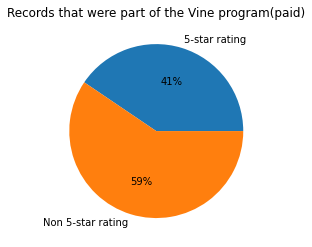

In [ ]:
p=np.array([Percentage_five_star_vine,1-Percentage_five_star_vine])
labels=["5-star rating","Non 5-star rating"]
plt.pie(p,labels=labels,autopct='%1.0f%%')
plt.title("Records that were part of the Vine program(paid)")
plt.show()

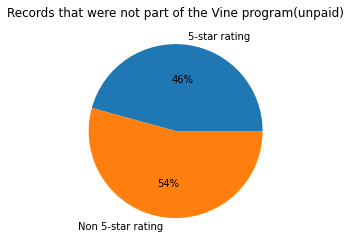

In [ ]:
p=np.array([Percentage_five_star_vine_Unpaid,1-Percentage_five_star_vine_Unpaid])
labels=["5-star rating","Non 5-star rating"]
plt.pie(p,labels=labels,autopct='%1.0f%%')
plt.title("Records that were not part of the Vine program(unpaid)")
plt.show()